In [ ]:
"""
 *  Copyright (c) Sanjula Madurapperuma and Team SOS. All Rights Reserved.
 *
 *  Sanjula Madurapperuma and Team SOS licenses this file to you under the Apache License,
 *  Version 2.0 (the "License"); you may not use this file except
 *  in compliance with the License.
 *  You may obtain a copy of the License at
 *
 *    http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing,
 * software distributed under the License is distributed on an
 * "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
 * KIND, either express or implied.  See the License for the
 * specific language governing permissions and limitations
 * under the License.
"""

In [1]:
# Adding all the imports
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
!pip install pandas --upgrade
import pandas as pd
!pip install scipy==1.2 --upgrade
import statsmodels.api as sm
import matplotlib
import json

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
Requirement already up-to-date: scipy==1.2 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
# Initializing matplotlib parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# URL for the main dataset in Google Drive
url = 'https://drive.google.com/open?id=1KhRlMBLA4I6G08nqjH63fOBiSxz5WBzV'

In [5]:
# Split the URL and take the id section of it
fluff, id = url.split('=')
print (id) # Verify that you have everything after '='

1KhRlMBLA4I6G08nqjH63fOBiSxz5WBzV


In [0]:
# Pass in the id of the URL and read the CSV file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('StackOverflowTagsUpdated.csv')  
data = pd.read_csv('StackOverflowTagsUpdated.csv', parse_dates=['date'])
# Dataset is now stored in a Pandas Dataframe

In [7]:
# Print overview of the dataset
data.head()

data.describe()

,questions,views_cum,views,views_percentage_change
count,24857.000000,2.485700e+04,2.485700e+04,24857.000000
mean,314.398801,1.510223e+07,8.776523e+05,6.303904
std,2061.149099,1.034782e+08,6.096462e+06,402.681396
min,0.000000,1.960000e+02,-7.245142e+06,-15897.590361
25%,12.000000,2.427150e+05,1.626100e+04,-14.081236
50%,44.000000,1.284516e+06,7.514500e+04,0.000000
75%,147.000000,6.182028e+06,3.404420e+05,9.591002
max,78786.000000,3.554072e+09,2.252552e+08,31757.858546


In [0]:
# Set the tag which is to be analysed here
tag = data.loc[data['tag'] == 'java-7']

In [9]:
# Initialize the date variable and print the start date and end date from the dataset
tag['date'] = pd.to_datetime(tag['date'])
tag['date'].min(), tag['date'].max()

(Timestamp('2017-06-01 00:00:00'), Timestamp('2018-06-01 00:00:00'))

In [10]:
# Remove column Sparkline from the analysis
cols = ['sparkline']
tag.drop(cols, axis=1, inplace=True)
tag = tag.sort_values('date')
tag.isnull().sum()

tag                        0
questions                  0
views_cum                  0
date                       0
views                      0
views_percentage_change    0
dtype: int64

In [0]:
# Group the tags by the date
tag = tag.groupby('date')['views'].sum().reset_index()

In [12]:
# Set the index of the tag as the date and show all indexes
tag = tag.set_index('date')
tag.index

DatetimeIndex(['2017-06-01', '2017-09-01', '2017-12-01', '2018-03-01',
               '2018-06-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [0]:
# Resample the time series and assign to new variable y
y = tag['views'].resample('MS').sum()

In [14]:
# Get data for the year 2017
y['2017':]

date
2017-06-01    533903
2017-07-01         0
2017-08-01         0
2017-09-01    432034
2017-10-01         0
2017-11-01         0
2017-12-01    555036
2018-01-01         0
2018-02-01         0
2018-03-01    467445
2018-04-01         0
2018-05-01         0
2018-06-01    616836
Freq: MS, Name: views, dtype: int64

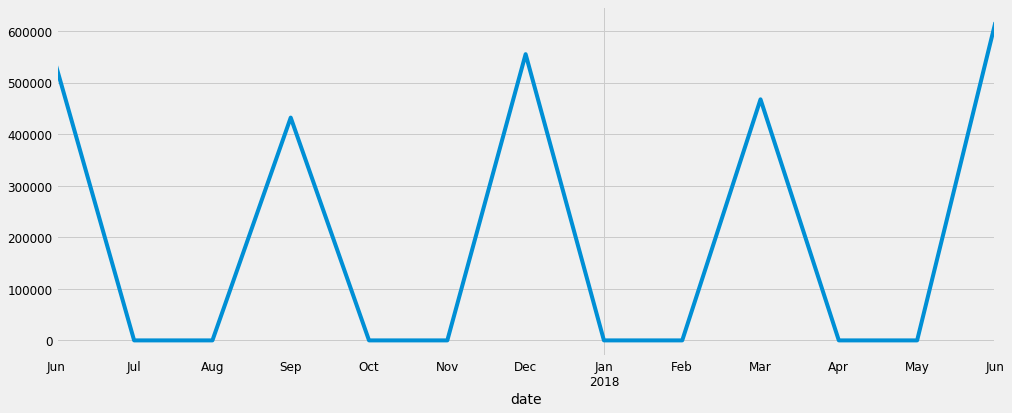

In [15]:
# Plot y
y.plot(figsize=(15, 6))
plt.show()

In [16]:
# Applying ARIMA (Autoregressive Integrated Moving Average) model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
# Grid search to find the best parameters for the model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:339.0139328114545
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:313.76736610027604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:33.17412300156026
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:317.29131572436734
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:291.0755992293256
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:340.8828034259546
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:315.76736610027604
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:317.31216573235844
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:286.66151475001845


In [18]:
# For debugging only
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8165    773.350     -0.001      0.999   -1516.554    1514.921
ma.L1          1.6052      1.926      0.834      0.405      -2.169       5.379
ar.S.L1       -0.8174    773.371     -0.001      0.999   -1516.597    1514.962
sigma2      4.281e+11   1.01e-06   4.26e+17      0.000    4.28e+11    4.28e+11


In [0]:
# Test issue with Correlation before running this block
# results.plot_diagnostics(figsize=(16, 8))
# plt.show()

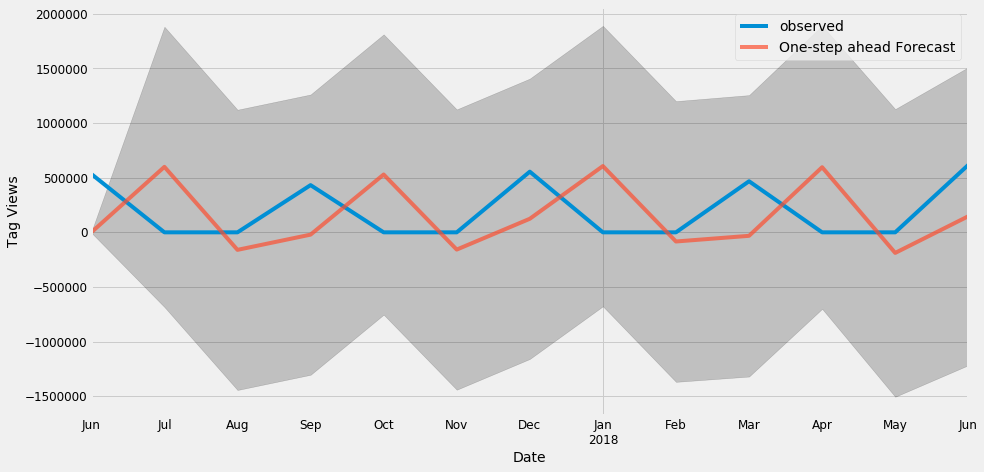

In [20]:
# Comparing real and predicted views for the tag within the year specified
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Tag Views')
plt.legend()
plt.show()

In [21]:
# Only for debugging
# Finding the Mean Squared Error - measures the average of the squares of the errors (Average squared difference between the estimated and real values)
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts are {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts are 200036440103.13


In [22]:
# Only for debugging
# Finding the Root Mean Squared Error - Difference between values predicted and the estimator of the real values
print('The Root Mean Squared Error of our forecasts are {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts are 447254.33


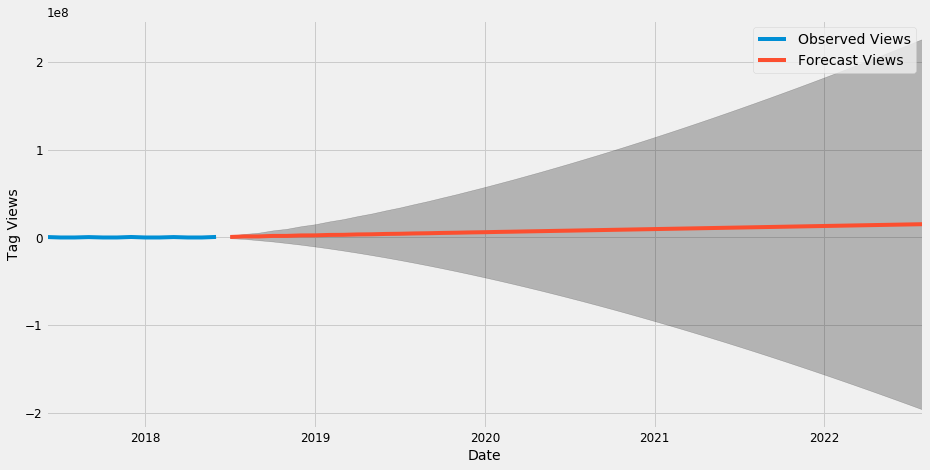

In [23]:
# Predicting the forecast for the tag specified
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed Views', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast Views')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Tag Views')
plt.legend()
plt.show()

In [0]:
# URL for the Bag of Words in Google Drive
url = 'https://drive.google.com/open?id=1qTfGqOw_f6vb_sZQAQMS7rMLN08-zD4t'

In [25]:
# Split the URL and take the id section of it
fluff, id = url.split('=')
print (id) # Verify that you have everything after '='

1qTfGqOw_f6vb_sZQAQMS7rMLN08-zD4t


In [0]:
# Pass in the id of the URL and read the CSV file
downloaded_bow = drive.CreateFile({'id':id}) 
downloaded_bow.GetContentFile('my_bow.csv')  
bow_data = pd.read_csv('my_bow.csv')
# Bag of Words is now stored in a Pandas Dataframe

In [27]:
# Print overview of the dataset
bow_data.head()

bow_data.describe()

,maven app engine plugin,cloud test lab,firebase crashlytics,cloud iot core,edge tpu,cloud iot edge,zync render,cloud dataflow,cloud datalab,cloud dataprep,cloud pub/sub,cloud composer,google genomics,google data studio,firebase performance monitoring,cloud identity for customers and partners,firebase authentication,cloud identity-aware proxy,cloud dataloss prevention api,security key enforcement,cloud hsm,google admin,google vault,google cloud search,google cloud load balancing,network service tiers,google docs,google+,cloud bigtable,dropbox,google app engine,google sites,microsoft azure,google mobile device management,wuala,openstack,amazon elastic compute cloud,google compute engine,cloud spanner,google cloud storage,...,impresspages,opengion,apache turbine,nette framework,asm.js.1,ember.js.1,laravel,meteor,novius os,dataviva,phalcon,lyme,apigility,apache struts 2,jamroom,express.js,fat-free framework,jwt,pantheon,scalatra,snap,asp.net core,crypton,open semantic framework,vibe.d,pylons,vraptor,brutos framework,webassembly,spark.1,protogrid,jhipster,gnu artanis,dweb framework,sails.js,pee,apache tiles,werc,repoze.bfg,phoenix (web framework)
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# Filter dataset against bag of words and create separate dataframe
frame = data
trendList = []

for row in bow_data:
  trendRow = data.loc[data['tag'] == row]
  if trendRow is not None:
    trendList.append(trendRow)
    

final_df = pd.concat(trendList, ignore_index=True)
print(final_df)


                tag  questions  ...  views_percentage_change sparkline
0           dropbox         97  ...                 0.000000       NaN
1           dropbox         96  ...               -28.814357       NaN
2           dropbox         73  ...                35.523910       NaN
3           dropbox         70  ...               -23.067296       NaN
4           dropbox         72  ...                 3.512274     █▂▃▁▂
5         openstack        167  ...                 0.000000       NaN
6         openstack        137  ...               -13.343867       NaN
7         openstack        116  ...                11.527414       NaN
8         openstack        121  ...                -1.681492       NaN
9         openstack        112  ...                 9.046533     ▄▅▁▅█
10      stackdriver         62  ...                 0.000000       NaN
11      stackdriver         35  ...                -2.868491       NaN
12      stackdriver         45  ...                35.574739       NaN
13    

In [29]:
# For debugging only
final_df['views_percentage_change'].max()

2614.8295748499

In [0]:
# Get the 50 biggest positive changes in views in the column views_percentage_change
trendingSkills = final_df.nlargest(50, 'views_percentage_change')

In [31]:
# Print the table with the 50 biggest positive changes in views in the column views_percentage_change
trendingSkills

,tag,questions,views_cum,date,views,views_percentage_change,sparkline
1235,angular,15697,66901196,2017-09-01,19258268,2614.829575,NaN
751,frege,0,41219,2017-09-01,15871,1802.997602,NaN
1404,appfuse,1,330635,2017-09-01,21605,1446.528275,NaN
237,ats,10,4512,2017-12-01,1271,594.535519,NaN
939,wxwidgets,57,2719144,2018-06-01,392829,363.832475,▁▁▁▁█
1426,fuelphp,6,434130,2018-03-01,52284,357.267798,NaN
602,racket,164,2405200,2017-12-01,206658,259.336475,NaN
402,prolog,365,7382043,2017-12-01,642779,239.070322,NaN
902,dafny,15,10047,2017-12-01,2162,218.879056,NaN
542,ml,12,348356,2017-12-01,25774,213.552311,NaN


In [32]:
# Top trending skills based on number of questions
# For debugging only
final_df['questions'].max()

78786

In [0]:
# Get the 50 biggest positive changes in views in the column questions
trendingNoOfQuestions = final_df.nlargest(50, 'questions')

In [34]:
# Print the table with the 50 biggest positive changes in views in the column questions
trendingNoOfQuestions

,tag,questions,views_cum,date,views,views_percentage_change,sparkline
290,javascript,78786,2587872428,2017-06-01,191952554,0.000000,NaN
291,javascript,71288,2754428951,2017-09-01,166556523,-13.230369,NaN
292,javascript,69406,2968267107,2017-12-01,213838156,28.387740,NaN
294,javascript,65041,3299615848,2018-06-01,160378882,-6.194646,▆█▆▅▁
293,javascript,62421,3139236966,2018-03-01,170969859,-20.047076,NaN
324,python,61579,2084518941,2018-06-01,173208520,0.906784,▁▂▅▇█
285,java,59260,2826221471,2017-06-01,202936438,0.000000,NaN
322,python,57950,1739658414,2017-12-01,190705074,49.258492,NaN
320,python,56175,1421185016,2017-06-01,146580286,0.000000,NaN
323,python,54364,1911310421,2018-03-01,171652007,-9.990855,NaN
